# FMCA Samplet Kernel Ridge Regression

We can use samplets for kernel ridge regression. It turns out that a diagonally scaled conjugate gradient method is quite efficient for solving the ridge regression problem in samplet representation

### first import modules

In [2]:
# import seems necessary to not crash matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import scipy
import scipy.sparse.linalg as sla
import time
import FMCA

### Create data points
(We force NumPy to use column major arrays for performance reasons)

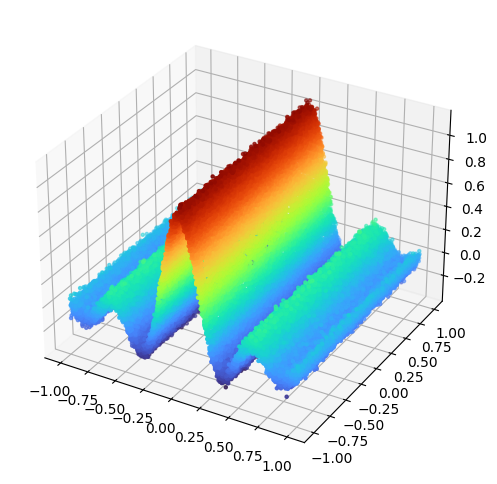

In [15]:
dim = 2
N = int(1e5)
pts = 2 * (np.array(np.random.rand(dim, N), order='F') - 0.5)
y = np.sin(4 * np.pi * pts[0]) / (4 * np.pi * pts[0]) + 0.03 * np.random.randn(1, N)
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(pts[0], pts[1], y[0], c=y[0], marker='.', cmap='turbo')
plt.show()

## create samplet compressed kernel matrix

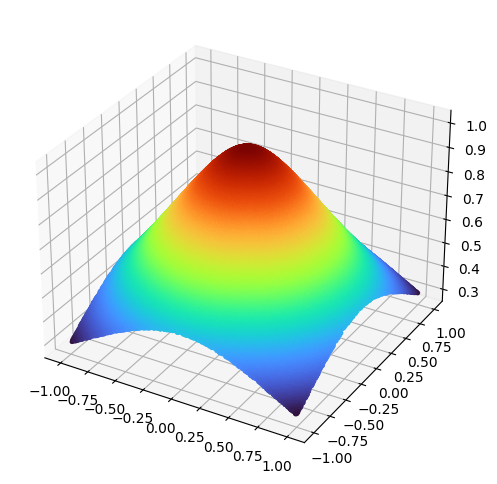

time tree setup:              0.5545089244842529 sec.
mpole deg:                    6
dtilde:                       6
eta:                          0.5
thres:                        1e-06
time kernel compression:      18.43171787261963 sec.
anz:                          39
compression error:            5.12493e-08


In [22]:
dtilde = 6
cov = FMCA.CovarianceKernel("Matern32", 1.)
k = cov.eval(np.zeros((dim, 1), order='F'), pts);
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(pts[0], pts[1], k[0], c=k[0], marker='.', cmap='turbo')
plt.show()
start = time.time()
ST = FMCA.SampletTree(pts, dtilde)
stop = time.time()
print('time tree setup:             ', stop - start, 'sec.')
start = time.time()
SKC = FMCA.SampletKernelCompressor(ST, cov, pts, 1./dim, 1e-6)
stop = time.time()
print('time kernel compression:     ', stop - start, 'sec.')
# return matrix and create lower triangular part
K = SKC.matrix()
K = K + scipy.sparse.triu(K, k=1).transpose()
# reorder points and data according to cluster ordering
pts = pts[:, ST.indices()]
y = y[:, ST.indices()]

## compute regressor

In [23]:
ridge_parameter = 1e-4
K += ridge_parameter * N * scipy.sparse.identity(N)
Ty = FMCA.sampletTransform(ST, y.transpose()).squeeze()
P = scipy.sparse.spdiags(1. / K.diagonal(), [0], N, N)
start = time.time()
Talpha, info = scipy.sparse.linalg.cg(K, Ty, M = P, tol = 1e-12)
stop = time.time()
alpha = FMCA.inverseSampletTransform(ST, Talpha.T)
print('elapsed time conjugate gradient: ', stop - start, 'sec.')
print('norm of the residual: ', la.norm(K @ Talpha - Ty) / la.norm(Ty))
rec_y = FMCA.inverseSampletTransform(ST, K @ Talpha).squeeze()

elapsed time conjugate gradient:  0.2974417209625244 sec.
norm of the residual:  3.9540871663625525e-13


## plot reconstruction

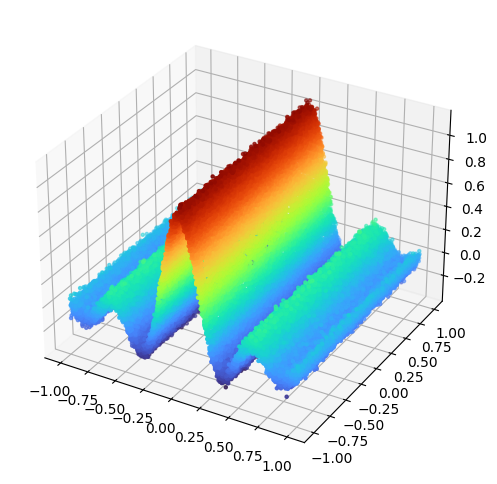

In [24]:
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(pts[0], pts[1], rec_y, c=rec_y, marker='.', cmap='turbo')
plt.show()